In [1]:
import torch
from torchsummary import summary

import tqdm
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import astropy.io.fits
import time

import scipy.ndimage
from scipy import signal

from torch.nn import functional as F

In [2]:
import sys
sys.path.append('../../')
from utils.ssd_model import SSD
from utils.ssd_model import DataTransform
# from utils.ssd_model import MultiBoxLoss
from utils.ssd_predict_show import SSDPredictShow

In [3]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
cygnus_r = astropy.io.fits.open('../../../../Cygnus/cygnus_fits/M1_fits_file/M1_cygnus_2.4.fits')[0]
cygnus_g = astropy.io.fits.open('../../../../Cygnus/cygnus_fits/I4_fits_file/I4_2.4_reg.fits')[0]

In [5]:
cygnus_g.header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    2                                                  
NAXIS1  =                10387                                                  
NAXIS2  =                11051                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = '        '                                                            
BUNIT   = 'MJy/sr  '           /Brightness (pixel) unit                         
EQUINOX =   2.000000000000E+03                                                  
RADESYS = 'FK5     '        

In [6]:
deg_to_pc = 1400*np.sin(np.deg2rad(1))
2/3600*deg_to_pc

0.013574093895664954

In [7]:
cygnus_r.data.shape, cygnus_g.data.shape

((11051, 10387), (11051, 10387))

In [8]:
def remove_nan(data1):
    # fits???????????????max?????
    mask1_10 = (data1==data1)
    mask1_1010 = np.where(mask1_10, 0, 1)
    label1, name1 = scipy.ndimage.label(mask1_1010)
    data_areas1 = scipy.ndimage.sum(mask1_1010, label1, np.arange(name1+1))
    minsize1 = 1000
    data_mask1_10 =  (data_areas1 < minsize1)&(0 < data_areas1)
    small_mask1_10 = data_mask1_10[label1.ravel()].reshape(label1.shape)
    data1[small_mask1_10] = np.nanmax(data1)

    return data1

In [9]:
# data_ = np.concatenate([cygnus_r.data[:,:,None], cygnus_g.data[:,:,None]], axis=2)

In [10]:
# データのnanを無くす
data_ = np.concatenate([remove_nan(cygnus_r.data[:,:,None]), remove_nan(cygnus_g.data[:,:,None])], axis=2)
# data_[data_ != data_] = 0

In [11]:
np.max(data_)

nan

In [12]:
def norm_median(data):
    min_ = np.min(data)
    data -= min_
    med = np.median(data)
    data /= med*2
    data = np.clip(data, None, 15)
    return data

In [13]:
def normalize(array):
    """
    入力：（y, x, 2 or 3）
    出力：（y ,x, 2 or 3）
    """
    gauss_list = []
    s = array.shape[2]
    for k in range(s):
        cut_data_k = array[:,:,k]
        cut_data_k = norm_median(cut_data_k)
        gauss_list.append(cut_data_k[:,:,None])                           

    cut_data = np.concatenate(gauss_list, axis=2)
    return cut_data

In [14]:
def resize(data, size):
    cut_data = np.swapaxes(data, 1, 2)
    cut_data = np.swapaxes(cut_data, 0, 1)
    cut_data = torch.from_numpy(cut_data)
    cut_data = cut_data.unsqueeze(0)
    resize_data = F.interpolate(cut_data, (size, size), mode='bilinear', align_corners=False)
    resize_data = resize_data.permute(0, 2, 3, 1)
    resize_data = np.squeeze(resize_data.detach().numpy())
    
    return resize_data

In [15]:
def conv(obj_size, obj_sig, data, cut_shape):
    """
    入力：（y ,x, 2 or 3）
    出力：（size ,size, 2 or 3）
    -------------------------------
    切り出したデータがobj_sizeより大きければ、smoothingをする
    小さければ、そのまま返す。
    """
    if cut_shape>obj_size:
        fwhm = (data.shape[0]/obj_size)*2
        sig3 = fwhm/(2*(2*np.log(2))**(1/2))
        sig2 = (sig3**2-obj_sig**2)**(1/2)

        kernel = np.outer(signal.gaussian(8*round(sig2)+1, sig2), signal.gaussian(8*round(sig2)+1, sig2))
        kernel1= kernel/np.sum(kernel)

        conv_list = []
        for k in range(data.shape[2]):
            cut_data_k = data[:,:,k]
            lurred_k = signal.fftconvolve(cut_data_k, kernel1, mode='same') 
            conv_list.append(lurred_k[:,:,None])                           

        pi = np.concatenate(conv_list, axis=2)
    else:
        pi = data
    return pi

In [16]:
def cut_data(data_, many_ind, cut_shape):
    data_list = []
    position_list_ = []
    for i in many_ind:
        x_min = i[1]-cut_shape/5
        x_max = i[1]+cut_shape+cut_shape/5
        y_min = i[0]-cut_shape/5
        y_max = i[0]+cut_shape+cut_shape/5
        data_c = data_[int(y_min):int(y_max), int(x_min):int(x_max)].view()
        if np.max(data_c) == np.max(data_c):
            d = copy.deepcopy(data_c)
            d = conv(300, sig1, d, cut_shape)
            d = d[int(cut_shape/5):int(cut_shape*6/5), int(cut_shape/5):int(cut_shape*6/5)]
            
            flag = True
            for dim in range(d.shape[2]):
                non_zero_count = np.count_nonzero(d[:,:,dim])
                if non_zero_count>=d.shape[0]*d.shape[1]*3/4:
                    pass
                else:
                    flag = False
            if flag:
                d = normalize(d)
                d = resize(d, 300)
                data_list.append(d)
                position_list_.append([int(y_min)+int(cut_shape/5), int(x_min)+int(cut_shape/5)])
        else:
            pass
    
    return data_list, position_list_

In [17]:
sig1 = 1/(2*(np.log(2))**(1/2))

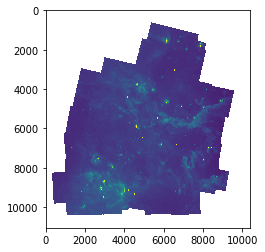

In [18]:
plt.imshow(data_[:,:,1], vmin=-1, vmax=255)

In [19]:
input_size = 300
color_mean = (0, 0)
classes = ['ring']

ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': input_size,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
#     'bbox_aspect_num': [4, 4, 4, 4, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ   
#     'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
#     'aspect_ratios': [[2], [2], [2], [2], [2], [2]],
}

In [20]:
net_w = SSD(phase='inference', cfg=ssd_cfg)
net_weights = torch.load('earlystopping.pth')
net_w.load_state_dict(net_weights)

<All keys matched successfully>

In [21]:
torch.backends.cudnn.benchmark = True
device = torch.device(torch.device("cuda:0") if torch.cuda.is_available() else 'cpu')
net_w.to(device)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

#### 切り出すインデックスを計算

In [22]:
size_list = [150, 300, 600, 900, 1200, 1800, 2000, 2500, 3000]
# batch_lsit = [1500, 600, 500, 100, 60, 60, 20, 4, 4]
batch_lsit = [10000, 5000, 4000, 800, 500, 500, 300, 50, 50]
len(size_list), len(batch_lsit)

(9, 9)

In [23]:
star = time.time()
for kk in range(len(size_list)):
    size = size_list[kk]
    bb = batch_lsit[kk]
    ################### indexの計算 ###################
    cut_shape = (size, size)
    fragment = 4
    slide_pix = (int(round(cut_shape[0]/fragment)), int(round(cut_shape[1]/fragment)))
    print(size)
    print(slide_pix)
    
    shape = data_.shape
    x_num = int(shape[1]/slide_pix[1])-1
    y_num = int(shape[0]/slide_pix[0])-1
    print(x_num, y_num)

    x_idx = np.arange(cut_shape[1]/5, slide_pix[1]*x_num, slide_pix[1])
    y_idx = np.arange(cut_shape[0]/5, slide_pix[0]*y_num, slide_pix[0])
    x_ind, y_ind = np.meshgrid(x_idx, y_idx)
    
    l = []
    for x, y in zip(x_ind.ravel(), y_ind.ravel()):
        l.append([y, x])
    ind = np.array(l)
    ################### indexの計算 ###################
    
    ################### infer ###################
    result = []
    position = []
    batch = np.linspace(0, ind.shape[0], bb)
    for i in tqdm.tqdm(range(len(batch)-1)):
        #indを等分して、データを切り取り、推論する
        cut_ind = ind[int(batch[i]):int(batch[i+1])]
        
#         position.append(cut_ind)
        data_list, p_list = cut_data(data_, cut_ind, cut_shape[0])
        
        if len(data_list) == 0:
            pass
        else:
            p_data = np.array(data_list)
            p_data = p_data.astype(np.float32)
            p_data = torch.from_numpy(p_data)
#             print(p_data.shape)
            pp_data = p_data.permute(0 ,3, 1, 2)

            with torch.no_grad():
                net_w.eval()
                pp_data = pp_data.to(device)
                detections = net_w(pp_data)
                result.append(detections.to('cpu').detach().numpy().copy())
                position.append(p_list)
                
#     print(result)
    aaaa = result[0]
    for i in tqdm.tqdm(range(1, len(result))):
        aaaa = np.concatenate([aaaa, result[i]])
        
    positions = position[0]
    for i in range(1, len(position)):
        positions = np.concatenate([positions, position[i]])
        
     ################### infer ###################
    
    print(cut_shape[0])
#     np.save('result_10/result_ring_select_csize%s.npy'%cut_shape[0], aaaa)
#     np.save('result_10/position_ring_select_csize%s.npy'%cut_shape[0], positions)
print(time.time()-star)

  0%|          | 0/9999 [00:00<?, ?it/s]

150
(38, 38)
272 289


  4%|▍         | 224/4999 [00:00<00:02, 2232.99it/s]

150
300
(75, 75)
137 146


  5%|▍         | 193/3999 [00:00<00:01, 1926.75it/s]

300
600
(150, 150)
68 72


  4%|▍         | 32/799 [00:00<00:02, 314.62it/s]

600
900
(225, 225)
45 48


  3%|▎         | 16/499 [00:00<00:03, 151.44it/s]

900
1200
(300, 300)
33 35


  3%|▎         | 16/499 [00:00<00:03, 152.40it/s]

1200
1800
(450, 450)
22 23


  3%|▎         | 10/299 [00:00<00:03, 94.21it/s]

1800
2000
(500, 500)
19 21


  4%|▍         | 2/49 [00:00<00:02, 17.92it/s]

2000
2500
(625, 625)
15 16


  4%|▍         | 2/49 [00:00<00:02, 19.18it/s]

2500
3000
(750, 750)
12 13


100%|██████████| 4/4 [00:00<00:00, 6314.35it/s]

3000
1273.7087817192078


In [25]:
1273.7087817192078/60

21.22847969532013